## By Diana Sernas, Evan Forletta, Kevin Vivian, Marissa van Rhijn. 

Prime numbers are the atomic components of natural numbers. What makes natural numbers fun is that we can throw them on the ground, spread them out, stack them up, arrange them, etc––like marbles or tiles you know? Primes can be fun to visualize because of this. In this report, we look essentially at two of these more rigid properties of the collection of prime numbers. First, we play a sort of game with these marbles and make some cool spirals out of them. Second, we analyze not the primes themselves, but the spaces between them, in their gaps. Along the way, we use Pillow and Matplotlib to help visualize these fun games! 

Please forgive us for the length of this report... it's a bit over the page limit, but we figure its fine with the number of large pretty pictures we have. 

To begin, we need to reinitialize The Sieve.

## A (faster) sieve

The code bellow adapts the sieve used in class. At each sieve, instead of constantly initializing arrays of `False`s to overwrite the initial `True`s, we preinitialize a list of `Flase`s to draw from during the sieving process. For large $n$, our computers' memory was dropping significantly with the original implemententation. In contrast, this code had almost no impact, and runs about 20 times faster than the original sieve. For comparison, the command `np_prime_bools(10**8)` runs in about 1 second, whereas the original (optimized) sieve took about 20. Below this, we prepare a function that yields a list of the actual prime numbers up to $n$.

In [ ]:
# Load in the good folks
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def np_prime_bools(n):
    '''
    Using the seive, this function returns a list of n+1 booleans, representing 
    the numbers 0 through n. The booleans are true where the index is prime, and
    false where else. This function in particular makes use of numpys efficency,
    see explaination above. This executes about 15 times faster than prime_bools
    for large n.
    '''
    
    # One main bit of efficency: instead of recreating false lists of the appropriate
    # size each sieve, we initialize a np array of Falses to draw from in the loop below
    max_false = ((n-2)//2)
    false_list = np.full(max_false, False, dtype="Bool")
    
    # Start with the list of bools, and set 0,1, and even numbers to false:
    prime_bools = np.full(n+1, True, dtype="Bool")
    prime_bools[:2] = [False, False]
    prime_bools[4::2] = false_list[:((n-2)//2)]
    
    p = 3
    sqrt = np.sqrt(n)
    while p <= sqrt:
        if prime_bools[p]:
            # This is the length of the list slice below, again we draw
            # from the pre-initialized false array
            length = ((n - p*p)//p) + 1 
            prime_bools[p**2::p] = false_list[:length]
        p += 2
    
    # Return the list of bools
    return prime_bools

In [ ]:
def np_prime_list(n):
    bools = np_prime_bools(n)
    numbers = [i for i in range(0,n+1) if bools[i]]
    return numbers

## Ulam spirals

If you have some graph paper and put the number 1 in the center, you can 'spiral' the numbers 2, 3, 4, ... out around it. If you highlight *prime* numbers as you go, interesting patterns appear. These are called Ulam spirals, named after a person who first noticed this. The huge block of code below is a multipurpose, Ulam spiral generator. We chose to put it into one function because the variants (coloring by modulus or graphing quadratics, for example) only changed the code slightly. While it is slightly more wordy to deal with this, we hope that the code is still clear.

In [ ]:
def ulam(n, start=1, size=1, mod_colors=(1, [[0,0,255]]), quadratic_coefficients=None):
    '''
    This code is a multipurpose, Ulam spiral generating function. The arguments are:
    -- n: The image will be n x n pixles, and thus have n^2 numbers inside,
    -- start: this is the number at the start of the spiral,
    -- size: when the spiral is rendered, this is the factor by which the pixles are
             scaled. A size of 5 turns one pixle into a 5x5 pixle in the final image,           
    
    -- mod_colors: this is a 2-tuple with the following format.
        - modulus: the number modded by
        - colors: a list of modulus number of 1x3 lists, representing the colors for
                   each remainder mod the modulus, from 0 to modulus-1
        Note that the default of mod_colors=(1, [[0,0,255]]) colors every prime blue.
        
    -- quadratic_coefficients: this is a 3-tuple (a,b,c) which plots the quadratic ax^2+bx+c
        
    In making the spiral, the code keeps track of a 'cursor' and the number to be placed 
    at each point. The main loop draws 4 lines: first right, then up, left, and down.
    At each turn, prime pixels are colored first by modulus, then by quadratic values.
    '''
    
    ### Initialization ##############################################
    
    # First, require that n be odd so our picture can have an
    # easy to access 'center'
    if n%2 == 0:
        n = n + 1
    
    # Get primes bools up to (start-1) + n**2, this is the largest
    # number that will appear in our grid
    primes = np_prime_bools((start-1) + n**2)
    
    # Initialize empty grid
    grid = np.full((n,n,3), [255,255,255], dtype="uint8")
    
    # Quadratic and mod colors defined here
    quad_color = [255,150,0] 
    prime_and_quad_color = [255,0,0]
    modulus = mod_colors[0]
    colors = mod_colors[1]
    
    # Check to see if we're plotting a quadratic, and build a list of the
    # values this quadratic takes. These are then checked against for
    # coloring in the main loop below
    quad_values = [] # Since check happens in the loop anyways 
    if quadratic_coefficients:
        a, b, c = quadratic_coefficients
        quad_value = c
        quad_index = 1
        
        # loop through values untill we're out of the range of our grid
        while quad_value <= (start-1) + n**2:
            quad_values.append(quad_value)
            quad_value = a*(quad_index**2) + b*(quad_index) + c
            quad_index += 1
    
    # Put the position in the center, and drop the first value (one isn't prime)
    pos_x, pos_y = (n-1)//2, (n-1)//2
    grid[pos_y, pos_x] = [255,0,0]
    
    
    ### Main loop ##############################################
    # As mentioned, we index the drawing by the 'rings' that we draw them in.
    # At each step of the while loop we draw right, up, left, then down. At the
    # the very end of the loop we need to draw the very last 'right' line.
    # Color is handled at each step by first coloring according to modulus (if applicable),
    # then coloring (possibly over) according to whether it lies on the given quadratic.
    
    index = 1
    number = start
    while index < n:
        
        # Right
        for k in range(index):
            # Increment number and move right
            number, pos_x = number+1, pos_x+1
            
            if primes[number]:
                grid[pos_y, pos_x, :] = colors[number%modulus]
            
            if primes[number] and number in quad_values:
                grid[pos_y, pos_x, :] = prime_and_quad_color
            
            elif number in quad_values:
                grid[pos_y, pos_x, :] = quad_color
            
        # Up
        for k in range(index):
            # Increment number and move up
            number, pos_y = number+1, pos_y-1
            
            if primes[number]:
                grid[pos_y, pos_x, :] = colors[number%modulus]
            
            if primes[number] and number in quad_values:
                grid[pos_y, pos_x, :] = prime_and_quad_color
            
            elif number in quad_values:
                grid[pos_y, pos_x, :] = quad_color
    
        # Left
        for k in range(index+1):
            # Increment number and move left
            number, pos_x = number+1, pos_x-1
            
            if primes[number]:
                grid[pos_y, pos_x, :] = colors[number%modulus]
            
            if primes[number] and number in quad_values:
                grid[pos_y, pos_x, :] = prime_and_quad_color
            
            elif number in quad_values:
                grid[pos_y, pos_x, :] = quad_color
        
        # Down
        for k in range(index+1):
            # Increment number and move down
            number, pos_y = number+1, pos_y+1
            
            if primes[number]:
                grid[pos_y, pos_x, :] = colors[number%modulus]
            
            if primes[number] and number in quad_values:
                grid[pos_y, pos_x, :] = prime_and_quad_color
            
            elif number in quad_values:
                grid[pos_y, pos_x, :] = quad_color
    
        # We increment the 'index' by 2. This makes sense if you notice that
        # the R-U-D-L loops above have lengths of both index and index+1
        index += 2

    # Draw the last row
    for k in range(n-1):
        # Increment number and move right
        number, pos_x = number+1, pos_x+1
        
        if primes[number]:
            grid[pos_y, pos_x, :] = colors[number%modulus]
            
        if primes[number] and number in quad_values:
            grid[pos_y, pos_x, :] = prime_and_quad_color 
            
        elif number in quad_values:
            grid[pos_y, pos_x, :] = quad_color

    ### Rendering ##############################################
    # The main bit here is if a larger size argument was passed. If this is the case,
    # we initialize a larger array, and use some list slicing to 'copy' the original pixles
    # over to the appropritate spots. 
            
    # Make pic!
    if size != 1: 
        grid_larger = np.zeros((size*n,size*n,3), dtype="uint8")
        for i in range(size):
            for j in range(size):
                grid_larger[i::size, j::size, :] = grid
        img = Image.fromarray(grid_larger)
        display(img)  
    else:
        img = Image.fromarray(grid)
        display(img)

### Examples and observations: 

This is a simple Ulam spiral

In [ ]:
ulam(n=100, size=2)

The immediate pattern to notice is that there appear to be long, diagonal streaks of primes, occurring on slopes 1 and -1. We ask our first question

**Question:** Does this pattern change if we start with the center at *another* number other than 1? 

Our function handles this:

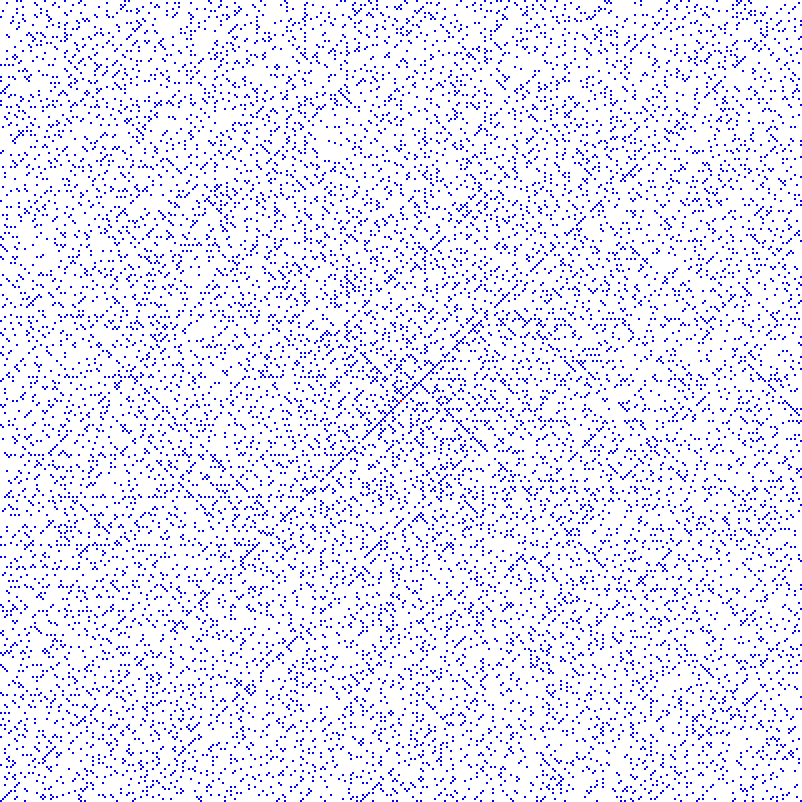

In [57]:
ulam(n=400, start=41, size=2)

Trying this out for several different starting values (not pictured) reveals that the pattern of diagonal distribution *does not change given another starting point.* This is spooky! A seemingly arbitrary change has no effect on the global distribution. This might suggest there's something deep about these patterns.

The case above demonstrates something striking: the 45 degree diagonal is almost entirely saturated with primes. Understanding the exact values that make up the diagonals (prime or not) is a start to understanding this. I have no proof, but the Wikipedia article on this states that diagonals in the spiral are described by the quadratic polynomial 
$$f(x) = 4x^2 + bx + c,$$

where $b$ is even. We verify this by graphing some quadratics on our spiral below. Prime values that lie on the quadratic are in *red*, whereas nonprime values that are still on the quadratic are $orange$.

The quadratic $f(x) = 4x^2 -2x + 50$

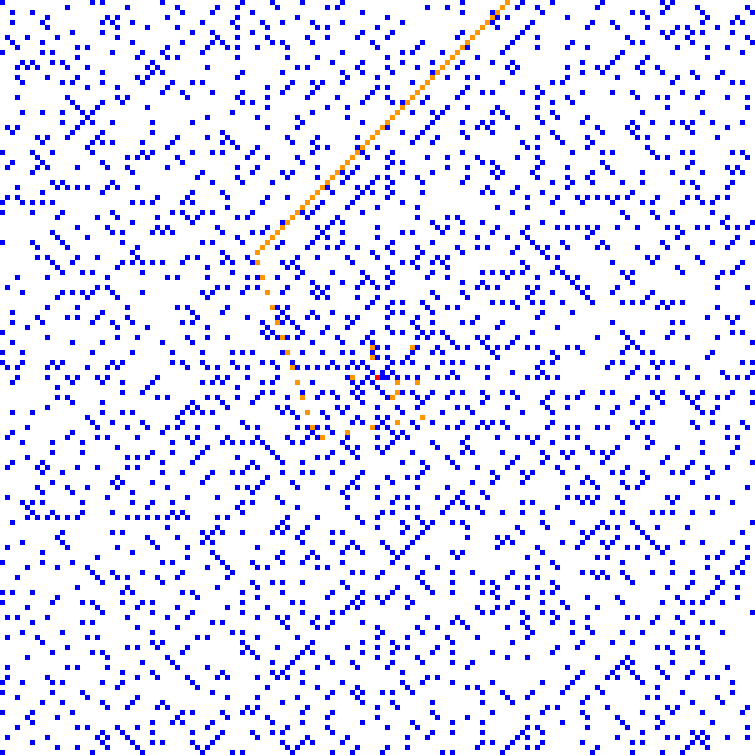

In [104]:
ulam(n=150, start=1, size=5, quadratic_coefficients=(4, -2, 50))

The quadratic $f(x) = 4x^2$

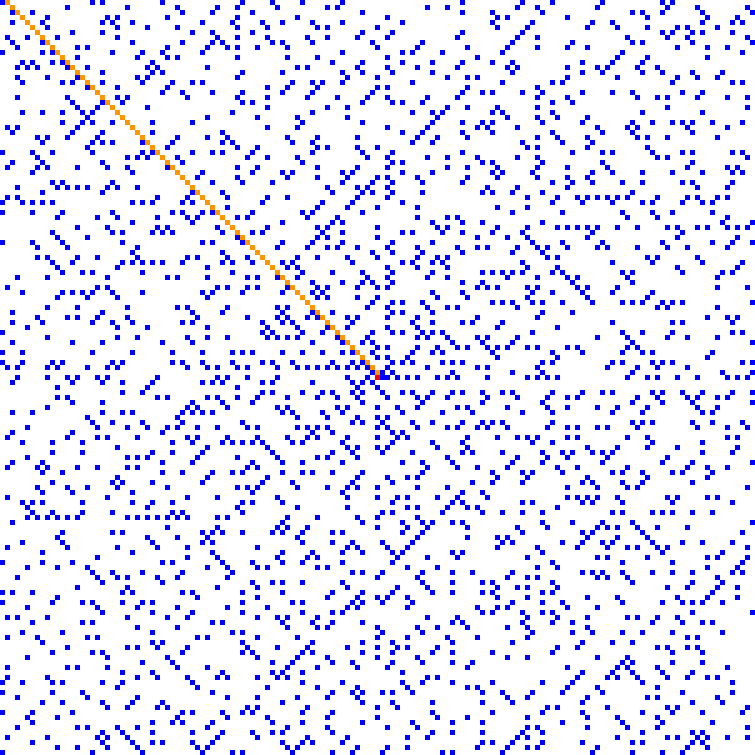

In [103]:
ulam(n=150, start=1, size=5, quadratic_coefficients=(4, 0, 0))

We appear to have a spiral then a straight line dictated by the coefficient $c$. If $b$ is even, then the polynomial will take either all even or odd values depending on $c$. For example, in the two pictures above, our quadratics hit no primes (there are no red pixels). If we hope to hit primes, we need that $c$ be odd. Lets try the quadratic $$f(x) = x^2 + x + 41$$

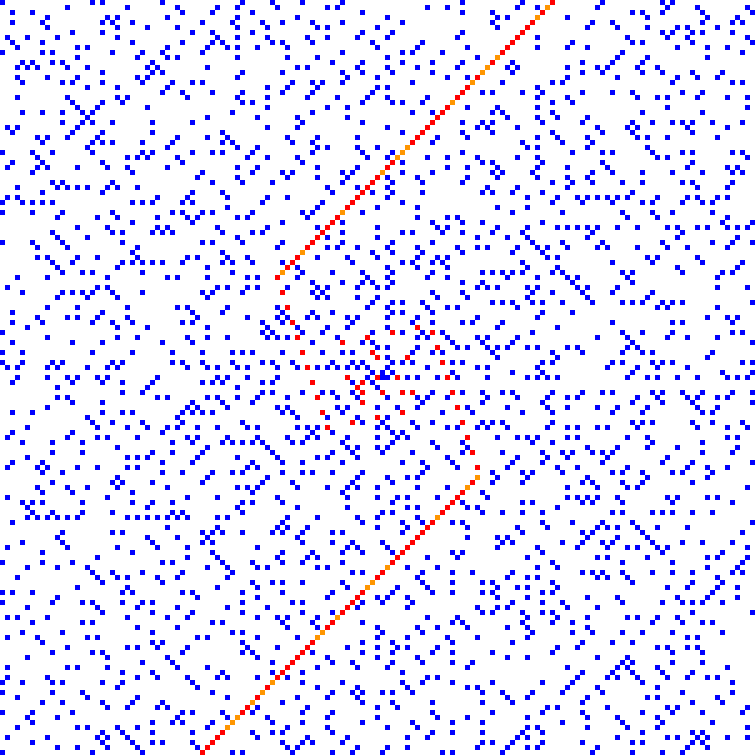

In [105]:
ulam(n=150, start=1, size=5, quadratic_coefficients=(1, 1, 41))

Awesome. This quadratic is due to Euler, and appears to have a very rich concentration of primes. As a last exploration, we look at how these patterns hold up if we color primes based off their remainders modulo some numbers. For the namesake, we plot red versus blue primes below.

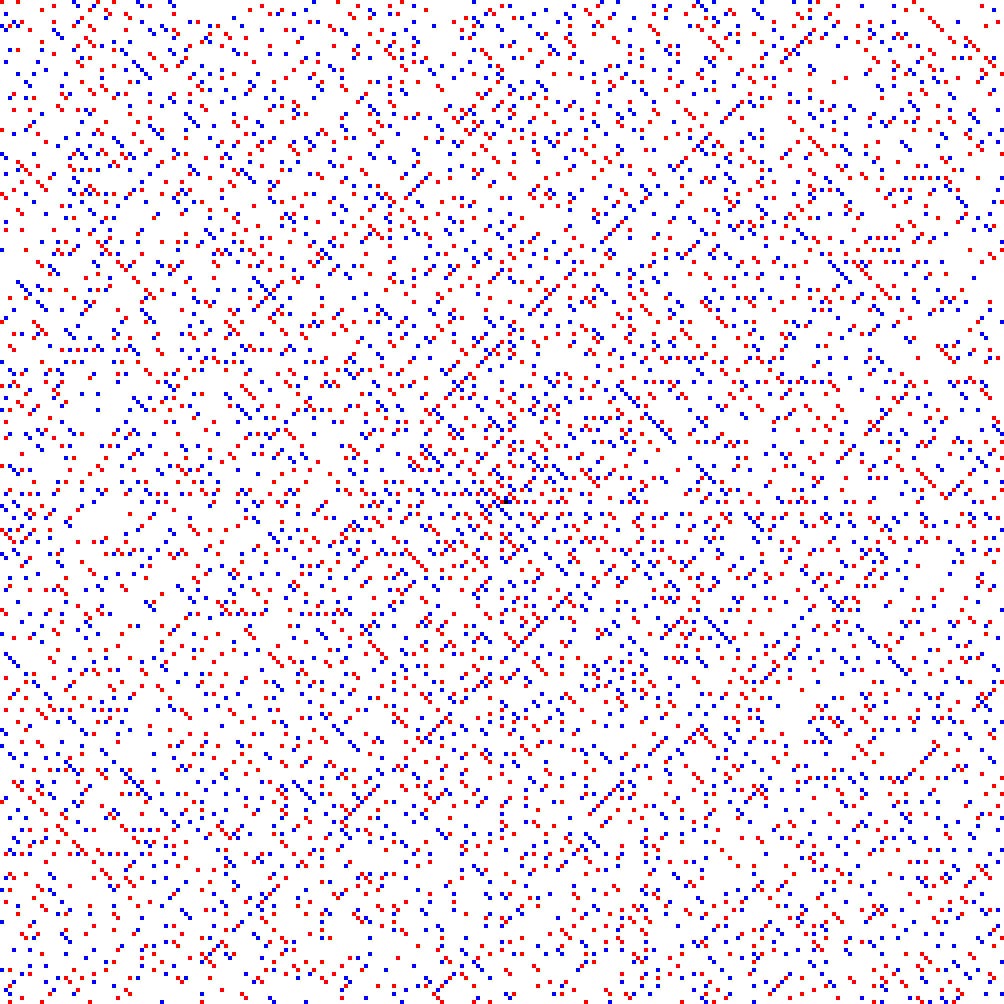

In [114]:
mod_4_colors = [[0,0,0],
                [255,0,0], # red primes are 1 mod 4
                [0,0,0],
                [0,0,255]] # blue primes are 3 mod 4

ulam(n=250, start=1, size=4, mod_colors=(4,mod_4_colors))

One main pattern to notice here is that -45 degree diagonals happen with consistent color (i.e. the remainder mod 4). That said, the +45 degree diagonals happen in alternating streaks of red, blue, red, blue, ... This would match up with the -45 degree ones be solid. This pattern caries over to some moduli but not others.

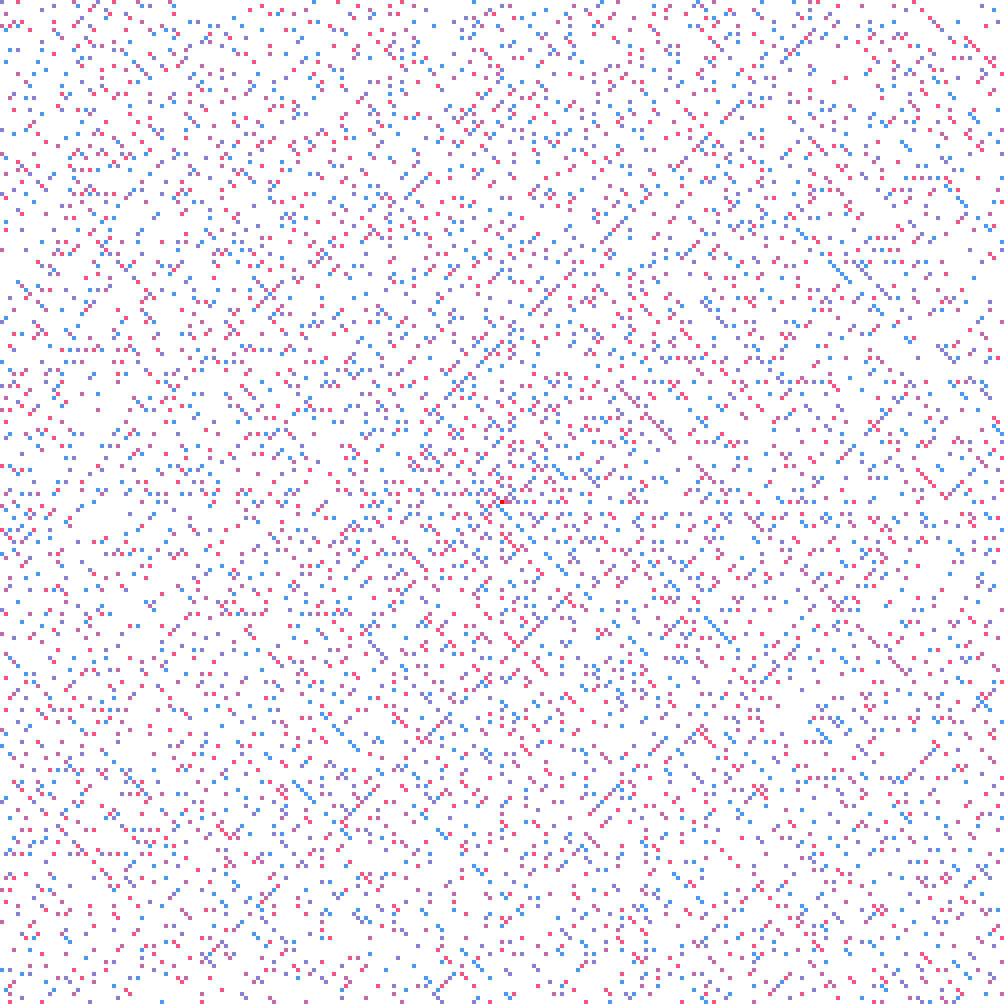

In [117]:
mod_8_colors = [[0,0,0], [255,84,130],[225,95,151],[195,107,172],[164,118,193],[134,129,213],[104,141,234],[74,152,255]]
ulam(n=250, start=1, size=4, mod_colors=(8, mod_8_colors))

The same pattern on -45 degree diagonals appears to happen, *but only below the line y=x*. This deviates from the study of primes, but we realize there might not be anything special about primes themselves here. The position of the colors mod some modulus is just determined by the modulus and the structure of the *numbers* within the spiral itself. As a last fun picture, without showing the code, this is a picture of the entire spiral colored mod 8 with the list of colors given above. The structure then makes more sense (even if we're not talking about primes anymore).

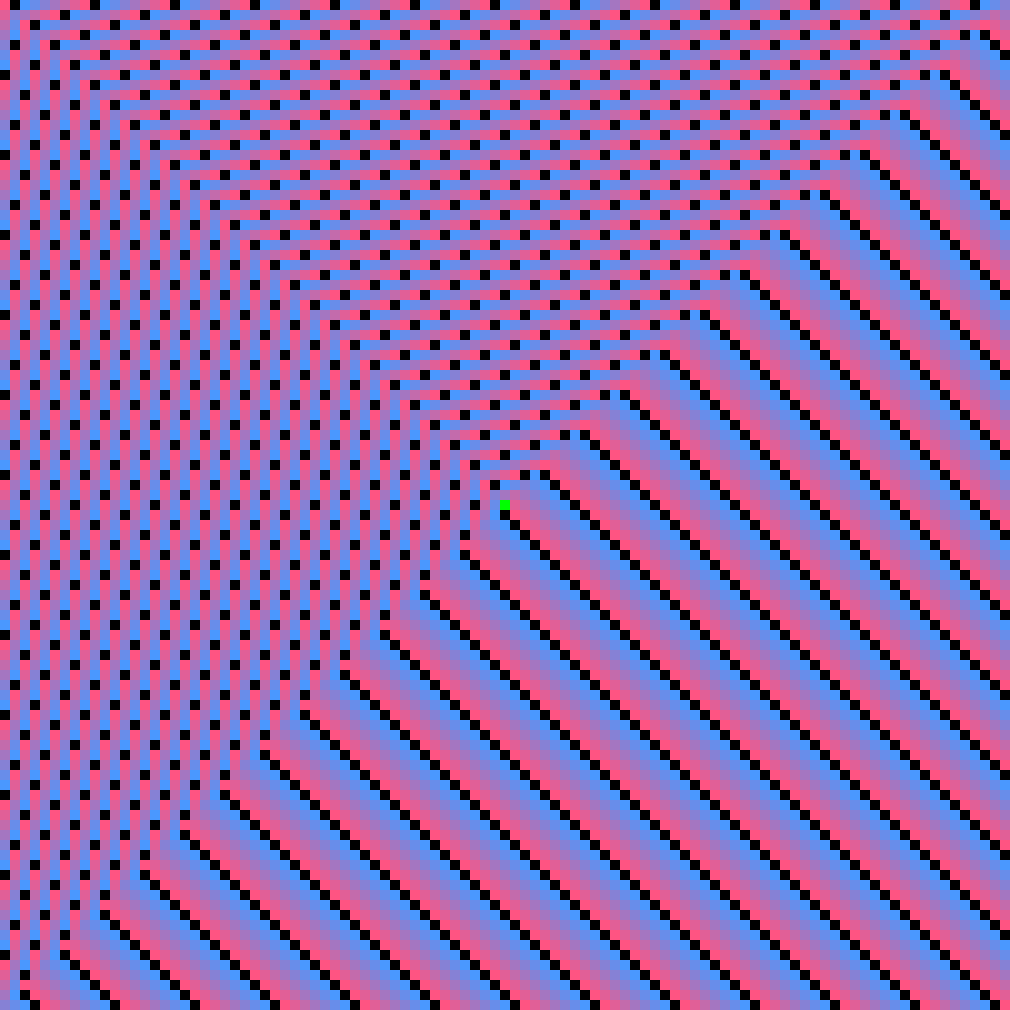

In [124]:
color_spiral(100, start=1, size=10, mod_colors=mod_8_colors)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA/IAAAPyCAIAAABQAHNvAAAkC0lEQVR4nO3dsW40eZXG4elVZUPIpo1EOuIWlnxTJmfDkSZH8gRGJnBGPFwAQ2Sn5ECwF2A5RbJD/IWf49mwTwV7qHbR9P+tep601DX+7cLwqpJz+PHr333x/zs83DZP//sPPzZPj+9v3dPP7dP3T83Tn616c/dUb6V3+Zv1zn+r90TvOW/We6K30rv8zXrnv91X7380zwAAgAhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4h5dff988/uHn/9U83dvtLr2V3nPerPdEb6V3+Zv1zn+r90TvOW/We5LY+/LlfzZPfa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeIe/ffvQPO6vzH7/v3/oXh14u2tvt8r0Lv+r9FZ6l79Z7/y3ek/0nvNmvSd6q+31vrZ3ZF9/4sosAABsmlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN7hj7/5S/P4TyuuzPYXat0qq/Se82a9J3orvcvfrHf+W70nes95s94TvVXf++dvDs3TH7/+XfO0v0Hraz0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEO9zfPTePv/vtV83Tv3370Dztr8z2F2rdKqv0Ln+z3vlv9Z7oPefNek/0VnqXv1nv/Lf76n39SXcLtr8Uu+YGra/1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEO/wze//0Tzub8H+8PNfNk//tOLKbH+hdm+3yvRWes95s94TvZXe5W/WO/+t3hO957x5a70v7aXY1y9/2j292A1aX+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAg3qG/3bXmFux3v/2qefq3bx8+/Ob+r0q8Vba322x6l/9Veiu9y9+sd/5bvSd6z3mz3pO99fbXXvtLsde6QetrPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQ79I8vdwv2h5//snn6p1Vv7n7rNlul95w36z3RW+ld/ma989/qPdF7zpv1nqzp/fM33Qz+8evfNU/HvEHraz0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEO/Q3tK51C/a7337VPL3c7Vu32Sq9y9+sd/5bvSd6z3mz3hO9ld7lb9Zb9TdZ+0uxiTdofa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeIeXX3/fPB7zFuy1bt/u7Tab3krvOW/We6K30rv8zXrnv9V7ordac5N1ezdofa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeIft3YK91u3bxNtse7tFp3f5X6W30rv8zXrnv9V7ovecN+s9udxN1u3doPW1HgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOId/vibvzSPt3cL9lq3b92iq/Se82a9J3orvcvfrHf+W70nes9586V6r3WTdXs3aH2tBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHiH+7vn5vHebsFeq9ctukrv8jfrnf9W74nec96s90RvpXf5m/u/asybrNu7QetrPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQ7fPP7fzSP3YKd//Y6vXu7Rae30nvOm/We6K30Ln+z3vlv9Z70vYk3Wbd3g9bXegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIh36G+VuQW7/K+6Vm/iLbq93d7Tu/yv0lvpXf5mvfPf6j3Re86bu6fbu8m6vRu0vtYDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAvO741hduwZ7z5jF73d6r9J7zZr0neiu9y9+sd/5bvSdj9u7tJuv2en2tBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHiH/oaWW7DV9nrd3qv0Ln+z3vlv9Z7oPefNek/0VpfrdZN1+V+V2OtrPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMSb/skdrPaWVX9/67W9jdpf2Pont2//yd+85um+eu/vnpunx7//tXmaeHvv/he/6n6rt9A7+63exX+V3krv8jfrnf12RW9/o3SNvvew4ibrmBJ7fa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeFN//XTM26h7uwV7rd6bp8fmaeLtvb3dGtS7/K/SW+ld/ma9s9/qLS7X22+Ga0m8ybrGmL2+1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEC86WVzt1H3dgv2Wr33d8/NU7cGK72z3+pd/FfprfQuf7Pe2W8De/vN4Cbr+K7V62s9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxJv2dhtVb3W53punx+apW4OV3uVv1jv7rd5C7+y3ehf/VdfqfW1/6yZrpbfqe32tBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHiT26iV3upyvfd3z83Tvd0a1Fvpnf1W7+K/Sm+ld/mbL9f70v7v4BpuslZ6K1/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN7kNuo5T/WeXK735umxeZp4a3BvtxX1Lv+r9FZ6l79Z7+y3V+rt/zf0WtxkrfbW62s9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxJvcRp39Vm99OmTv/d1z89RtxUrv7Ld6F/9Veiu9y9+8vd7+f0O3d6N0bzdZt9fraz0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEm9xGrfTO3hzYe/P02Dx1W7HSu/zNeme/1Vvonf02sPe1/e3ebpTqrRJ7fa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeNOYt0L3dhtVb3W53vu75+bp3m4r6q30zn6rd/Ffpbcas/el/d+FNbZ3o7Sntxqz19d6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiDf110DHvBW6t9uoeqvL9d48PTZPE28r7u2WpN7lf5XeSu/yN4/Z2/9vyrUk3ihdQ291rV5f6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACDe9LK5W6F7u42qt7pc7/3dc/PULclK7+y3ehf/VXorvVX/vylulI5Pb3W5Xl/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN60t1uheiu9s9+u6L15emyeuiVZ6V3+Zr2z3+otttf72v7WjdJKb6W38rUeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4k1uhVZ6K72zN694en/33Dzd2y1JvZXe2W/1Lv6rEntf2n9PruFGaaW32luvr/UAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQb3Ir9Jynek/0zn67ovfm6bF5mnhLcm+3M/Uu/6v0Vtvr7f8dey1ulFZ6q+31+loPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8Sa3Qme/1Vuf6i2u1Xt/99w8dTuz0jv7rd7Ff5Xequ/t/x27vZude7tRqrdK7PW1HgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOJNboVWemdv1nvG0+v03jw9Nk/dzqz0Ln+z3tlvd9b72v52bzc79VZ6qzF7fa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeNOYtzP3ditUb6V39uYVT+/vnpune7udqbfSO/vtznpf2n9vrLG9m509vZXe6lq9vtYDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAvKm/jjnm7cy93QrVW+md/XZF783TY/M08Xbm3m6F6l3+V+2tt/93zrUk3uxcQ2+lt7pcr6/1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEG962dztzL3dCtVb6Z29ecXT+7vn5qlboZXe2W/1Lv6r1vT2/85xs3N8eiu91ZpeX+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAg3rS325l6K72z3+qtT9vem6fH5qlboZXe5W/WW722v3Wzs9Jb6R3f5Xp9rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4k9uZld5K7+zNehc/vb97bp7u7Vao3kpv9dL+92gNNzsrvZXe8a3p9bUeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4k1uZ57zVO+J3tlv9danbe/N02PzNPFW6N5uo+pd/lf1/x28Fjc7K72V3vH1vb7WAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQLzJ7czZb/XWp3oLvdXleu/vnpunbqNWeme/vVJv/9/B7d2w3NvNTr2V3vH5Wg8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxJrczK72zN+s946nek8v13jw9Nk/dRq30Ln9z3/va/nZvNyz1VnorvSPwtR4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADiTWPektzb7Uy9ld7Zm/Uufnp/99w83dttVL1V3/vS/udqje3dsOzprfRWev89fK0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeFN/LXLMW5J7u52pt9I7+63e+rTtvXl6bJ4m3kbd2y3YNb39fyavJfGG5Rp6K72V3n8VX+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAg3vSyuVuSe7udqbfSO3uz3sVP7++em6duwVZj9vb/mXTDcnx6K72V3uV8rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4095uSeqt9M5+q7c+1VvcPD02T92CrS7X+9r+1g3LSm+ld3x6qzW9vtYDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAvMktyUpvpXf2Zr1nPN1X7/3dc/N0b7dg1/S+tP93XsMNy0pvpXd8equ+19d6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiDe5JXnOU70neme/1Vuf6i1unh6bp4m3YNfcvu3/f3QtblhWeiu949Nb+VoPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8Sa3JGe/1Vuf6i30Vnpnb17x9P7uuXl6rVuwa27f9v8/2t5Nx73dsNRb6R3f3np9rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4k1uSld7Zm/We8VTvid7Zb1f03jw9Nk/X3ILtr8ze/+JXzdPX9rd7u+mot9Jb6R3f9np9rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB405i3Ffd2S1JvpXf2Zr1nPN1X7/3dc/P0+Pe/Nk9/1l6KfWn/uWts76ZjT2+lt9I7vsReX+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAg3tRfTxzztuLebknqrfTOfqu3PtVbfHf7VfP05X++b55eS+JNxzX0VnorveMbs9fXegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIg3vWzutuLebknqrfTO3qz3jKdb6/2i+5O/OH791j0e0pg3HS9Hb6W30ju+a/X6Wg8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxpu3dVtzbLUm986d6T/TOfru53uN7dynWTcdKb6V3fHorvVXf62s9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxJsSbyvu7Zak3tlv9daneovt9R7fPzVP13DTsdJb6R2f3kpv5Ws9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxJvGvK24t1uSeiu9ld7ZmzfX+/r5rXl6LW46VnorvePTW+2t19d6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiDe5JTn7rd76VG+ht9I7e3P79PBw++F/7pjcdKz0VnrHp7faXq+v9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABBvckuy0jt7s94znuo92Vvv8f2tebq3G4d6K72V3vHprRJ7fa0HAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeJNbkvOnek/0zn6rtz7dWe/x/VPzdI3t3Tjs6a30VnrHp7cas9fXegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIg39dci93ZLUm+lt9I7e/Pmel8/vzVPryXxxuEaeiu9ld7x6a2u1etrPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMSbXnZ2S3JvtzP1zt6s94ynW+s9PNx++J87pjFvHF6O3kpvpXd8eqvL9fpaDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPGm7d2S3NvtTL3zp3pP9tZ7fH9rnrpxWOmt9I5Pb6W30lv5Wg8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxpsRbknu7nal39lu99enOeo/vn5qna7hxWOmt9I5Pb6W32luvr/UAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQbxrzluTebmfqrfRWe+t9/fzWPL0WNw4rvZXe8emt9Fbb6/W1HgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOJNbmfOfqu3PtVb6K3W9B4ebj/8zx2TG4eV3krv+PRWeqvEXl/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN7kdmald/ZmvWc81XtyfH9rnu7t5p/eSm+ld3x6K73VmL2+1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEC8ye3M+VO9J3pnv9VbHN8/NU/X2N7Nv57eSm+ld3x6K73VtXp9rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4U38dc2+3M/VWequ99b5+fmueXkvizb819FZ6K73j01vprS7X62s9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxJtednY7c2+3QvXO3qy3ODzcfvifO6Yxb/5djt5Kb6V3fHorvdWaXl/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN60vduZe7sVqnf+VO/J8f2teermX6W30js+vZXeSu/4Ltfraz0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEmxJvZ+7tVqje2W/1Fsf3T83TNdz8q/RWesent9Jb6R3fml5f6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACDeNObtzL3dCtVb6Z399vNb8/Ra3Pyr9FZ6x6e30lvpHV/f62s9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxJvcCp39Vm99qre4XO/h4fbD/9wxuflX6a30jk9vpbfSOz5f6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACDe5FZopXf2Zr1nPO16j+9vzdO93cDTW+mt9I5Pb6W30jsCX+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAg3uRW6Pyp3hO9s9+2vcf3T83TNbZ3A6+nt9Jb6R2f3kpvpfffw9d6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiDf110D3ditUb6V39tvPb83Ta0m8gbeG3kpvpXd8eiu9ld5/FV/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN70srNboXu7jap39ub26eHh9sP/3DGNeQPvcvRWeiu949Nb6a30LudrPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMSbtncrdG+3UfXOn3a9x/e35qkbeJXeSu/49FZ6K73j01ut6fW1HgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOJNibdC93YbVe/st23v8f1T83QNN/AqvZXe8emt9FZ6x6e36nt9rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB405i3Qvd2G1Vv1fe+fn5rnl6LG3iV3krv+PRWeiu949Nb+VoPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8Sa3UWe/1VufXqn38HD74X/umNzAq/RWesent9Jb6R3f3np9rQcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4k9uold7Zmy/We3x/a57u7Sac3kpvpXd8eiu9ld7xba/X13oAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIN7mNOn+q92RN7/H9U/N0je3dhOvprfRWesent9Jb6R1fYq+v9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABBv6q+f7u02qt6q7339/NY8vZbEm3Br6K30VnrHp7fSW+kd35i9vtYDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAvOllZ7dR93YLdk3v4eH2w//cMY15E+5y9FZ6K73j01vprfSO71q9vtYDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAvGl7t1H3dgt2Te/x/a156iZcpbfSOz69ld5K7/j0VnqrvtfXegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIg3Jd5G3dst2DW9x/dPzdM13ISr9FZ6x6e30lvpHZ/eSm/laz0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEm8a8jbq3W7Brel8/vzVPr8VNuEpvpXd8eiu9ld7x6a321utrPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMSb3IKd/XbI3sPD7Yf/uWNyE67SW+kdn95Kb6V3fHqr7fX6Wg8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxJrdgq2v1Ht/fmqd7u5Gmt9Jb6R2f3kpvpXd8eqvEXl/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN7kFuz86aV6j++fmqdrbO9GWk9vpbfSOz69ld5K7/j0VmP2+loPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8ab+2uvebsGu6X39/NY8vZbEG2lr6K30VnrHp7fSW+kdn97qWr2+1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEC86WVnt2DX3L49PNx++J87pjFvpF2O3kpvpXd8eiu9ld7x6a0u1+trPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMSbtncLds3t2+P7W/PUjbRKb6V3fHorvZXe8emt9FZ6K1/rAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIN6UeAt2ze3b4/un5ukabqRVeiu949Nb6a30jk9vpbfaW6+v9QAAEM+sBwCAeGY9AADEM+sBACCeWQ8AAPHMegAAiGfWAwBAPLMeAADimfUAABBvGvMW7Jrbt6+f35qn1+JGWqW30js+vZXeSu/49FZ6q+31+loPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8aZr3YL9YcV128PD7Yf/uWNyI63SW+kdn95Kb6V3fHorvVVir6/1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEG+63C3Yf/b0p83T4/tb83RvN8P0VnorvePTW+mt9I5Pb6W3GrPX13oAAIhn1gMAQDyzHgAA4pn1AAAQz6wHAIB4Zj0AAMQz6wEAIJ5ZDwAA8cx6AACIN625Bfvn9v7W67cPzdPj+6f+L/uw7d0M6+mt9FZ6x6e30lvpHZ/eSm91rV5f6wEAIJ5ZDwAA8cx6AACIZ9YDAEA8sx4AAOKZ9QAAEM+sBwCAeGY9AADEM+sBACDe9PqT9sps+7S/ofX6+e2Df9QlJd4MW0NvpbfSOz69ld5K7/j0Vnqry/X6Wg8AAPHMegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxppcv2yuz7dPDw23z1M2w8emt9FZ6x6e30lvpHZ/eSm+1ptfXegAAiGfWAwBAPLMeAADimfUAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIg3vX750+bx8f2teepmWKW30js+vZXeSu/49FZ6K73ju1yvr/UAABDPrAcAgHhmPQAAxDPrAQAgnlkPAADxzHoAAIhn1gMAQDyzHgAA4pn1AAAQ7/8AJD+OBDHxcj4AAAAASUVORK5CYII=

## Prime Gaps 
In this exploration, we create a list of the *gaps* between prime numbers, and explore their distribution. This function utilizes the `np_prime_list` function and some list slicing to get a list of the gap sizes.

In [14]:
def prime_gaps(P):
    P = np_prime_list(P)
    G = np.array(P[1:]) - np.array(P[:-1])
    return G

Below, we use a histogram to plot the distribution of these gaps.

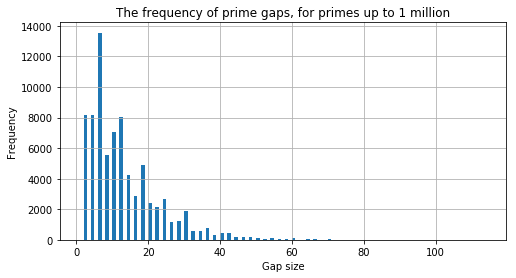

In [15]:
%matplotlib inline
plt.figure(figsize=(8, 4))  #  Makes the resulting figure 8in by 4in.
plt.hist(prime_gaps(1000000), bins=range(1,115)) #  Makes a histogram with one bin for each possible gap from 1 to 114.
plt.ylabel('Frequency')
plt.xlabel('Gap size')
plt.grid(True)
plt.title('The frequency of prime gaps, for primes up to 1 million')
plt.show()
#The Frequency of gaps from NTBK 3

We chose to look at prime gaps in two different ways. Our first plan was to graph the gap size versus the index of the gaps between consecutive primes which we obtained using a prime function and then list slicing. However, while it gave us a good idea of the frequency of low number gaps despite higher prime numbers, we were still unsure what value was the most frequent. Because of this we decided to include the histogram above. 

Surprisingly to us the gap size with the highest frequency was 6. We’re not entirely sure why this trend occurs but it seems to be consistent for all the values we tried.

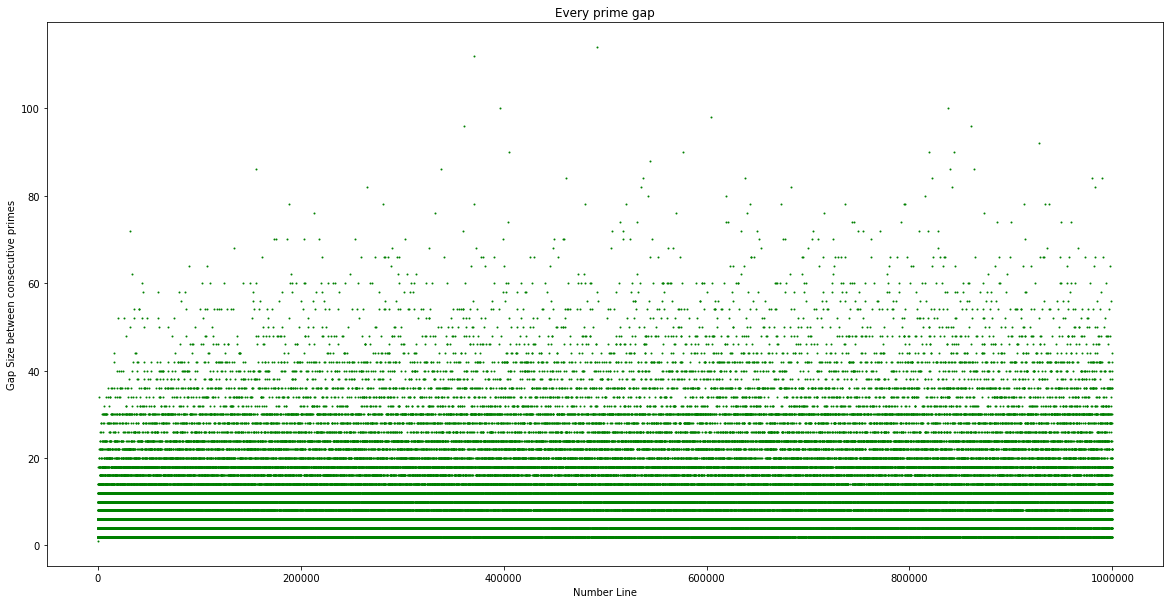

In [17]:
x_range = np.array(np_prime_list(10**6)[1::])
y_range = np.array(prime_gaps(10**6))
plt.figure(figsize=(20,10))
plt.scatter(x_range, y_range, alpha=1, c='green', s=1)
plt.xlabel('Number Line')
plt.ylabel('Gap Size between consecutive primes')
plt.title('Every prime gap')
plt.show()

After gaining more information from the histogram we decided to analyze the original visualization idea, graphing the gaps values versus their index, with this in mind. The first graph is rather cluttered, so we decided to graph every 100th value and to see what information that would give about the distribution of gap values as we approach larger values. Subsequently, we also included graphs below of every 1000th gap, and every 10000th gap. We decided to visualize the information this way because we can see that the certain values occur more frequently than others because the graph showed almost solid lines for the values of 2, 4, and 6 because they happened so often. Similarly, the graph shows that the distribution is close to even across the x-axis, meaning as the primes increase, we still have a high frequency of low value gaps. This is perhaps an interesting fact: *large primes can still occur together.*

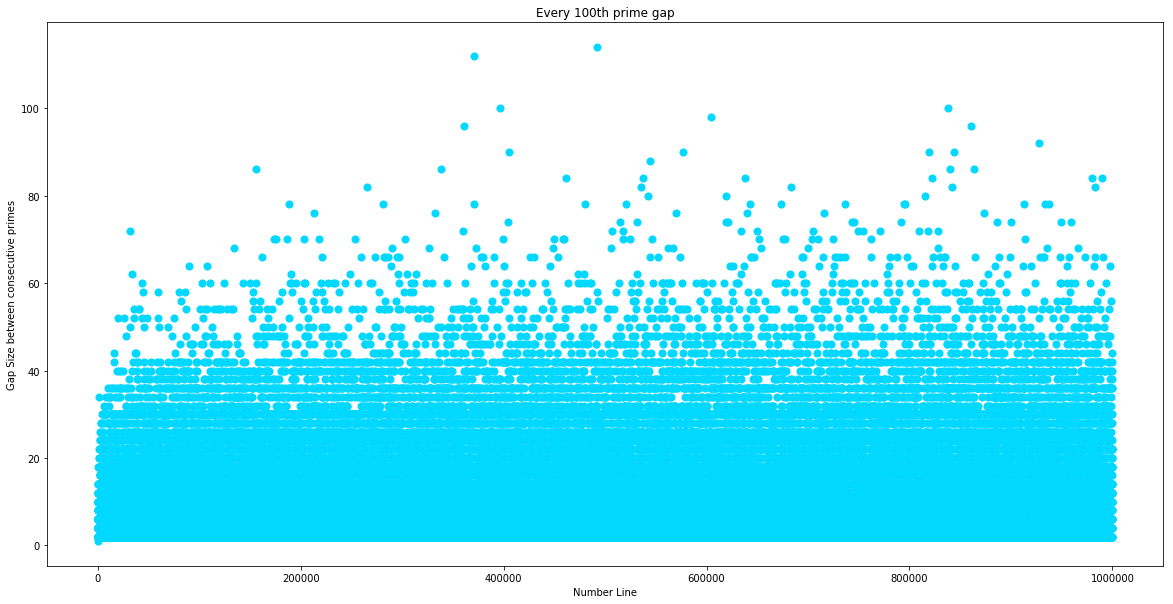

In [18]:
x_range2 = np.array(np_prime_list(10**6)[1::100])
y_range2 = np.array(prime_gaps(10**6)[::100])
plt.figure(figsize=(20,10))
plt.scatter(x_range, y_range, alpha=1, c='#00d8ff', s=50)
plt.xlabel('Number Line')
plt.ylabel('Gap Size between consecutive primes')
plt.title('Every 100th prime gap')
plt.show()

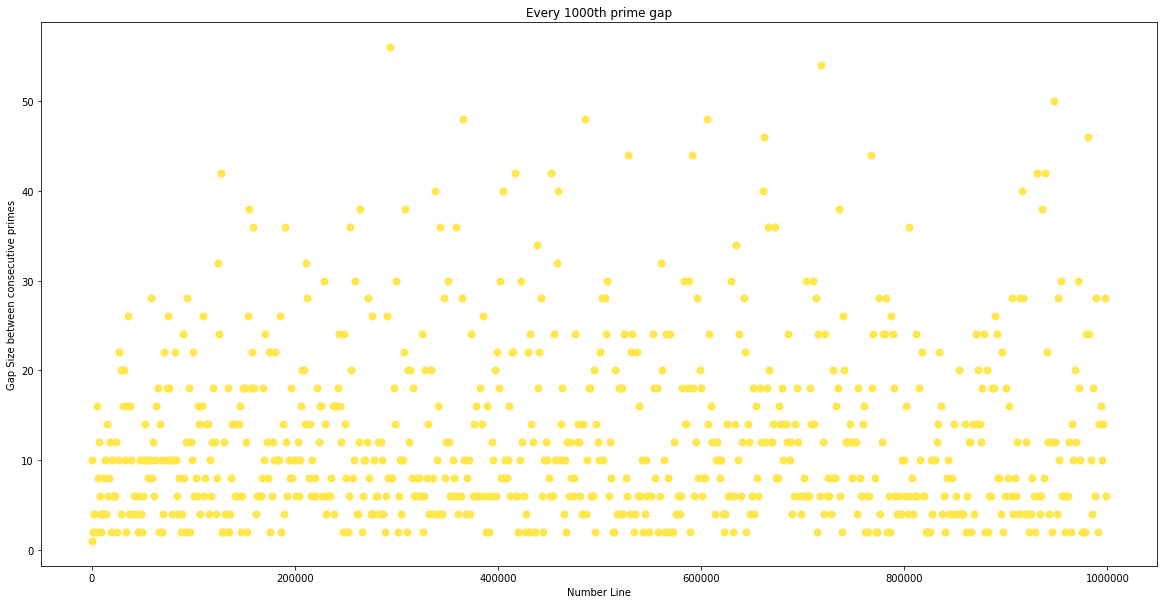

In [19]:
x_range3 = np.array(np_prime_list(10**6)[1::1000])
y_range3 = np.array(prime_gaps(10**6)[::1000])
plt.figure(figsize=(20,10))
plt.scatter(x_range2, y_range2, alpha=1, c='#ffe74c', s=50)
plt.xlabel('Number Line')
plt.ylabel('Gap Size between consecutive primes')
plt.title('Every 1000th prime gap')
plt.show()

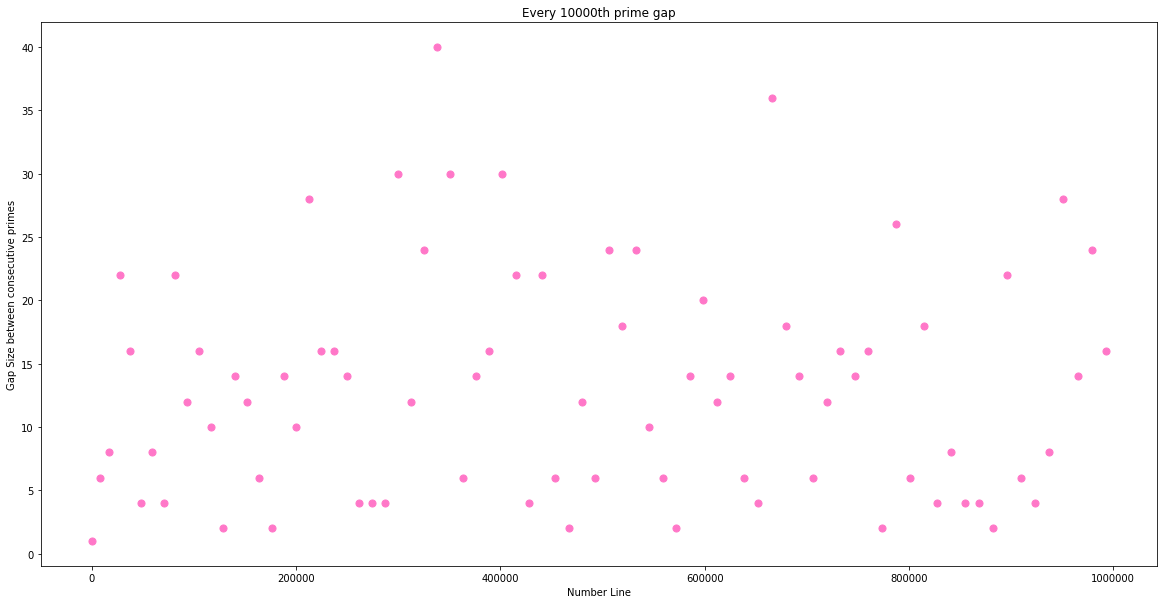

In [20]:
x_range4 = np.array(np_prime_list(10**6)[1::10000])
y_range4 = np.array(prime_gaps(10**6)[::10000])
plt.figure(figsize=(20,10))
plt.scatter(x_range3, y_range3, alpha=1, c='#ff77c8', s=50)
plt.xlabel('Number Line')
plt.ylabel('Gap Size between consecutive primes')
plt.title('Every 10000th prime gap')
plt.show()

Lastly we noticed that even though 6 was the most common gap value, the frequency of 2 and 4 were very high too. After some research we learned that prime triplets exist when the difference between the smallest and the largest of three consecutive primes is 6. Given that all prime gaps are even this means that the gaps are either 2-4 or 4-2. The below is a function that ran through the prime gaps list and found the cases where this happens. 

In [21]:
#find the number of triple primes by counting how many gaps of 2 are followed by 4 and how many are 4 followed by 2
def prime_triplets(n):
    G = prime_gaps(n)
    prime_triplets = 0
    for i in range(len(G)-1):
        if G[i] == 2:
            if G[i+1] == 4:
                prime_triplets += 1
        elif G[i] == 4:
            if G[i+1] == 2 and G[i-1]!=2: #don't double count triplets
                prime_triplets += 1
    return prime_triplets

In [22]:
def triplet_percent(n):
    percent = (3*prime_triplets(n))/len(np_prime_list(n))
    return percent*100

In [23]:
def pair_prime_percent(n):
    G = prime_gaps(n)
    count2 = 0
    for i in range(len(G)-1):
        if G[i] == 2:
            count2 +=1
    percent = count2*2/len(np_prime_list(n))
    return percent*100

In [24]:
triplet_percent(10**8)

5.539642329932283

In [25]:
pair_prime_percent(10**8)

15.284750119544455

We decided to see not only how many prime triplets there are but approximately what percent of primes are in a triplet. Using the above functions we found that about 5.54% of primes are in triplets. Comparatively aprroximately 15.28% of primes are pair primes, meaning they have a gap size of 2. So a prime is 3 times more likely to be in a pair than a triplet which makes sense seeing as there's more factors for being in a triplet. 

# Conclusion: Unanswered Questions

During our explorations, we have explored prime spirals and prime gaps. We have at least two questions unanswered. We figured this would be a cool concrete conclusion.

1.) Why are the diagonals of the Ulam spiral described by quadratic equations, and what makes some quadratics more rich in primes than others?

2.) What's the deal with the number 6? Sexy primes are cool, but why?!